In [1]:
# testing extended search area piv from pyprocess
# this won't show any difference since 0.23 version
# because we incorporate the extended_seach_piv
# 

In [2]:
import numpy as np
from scipy.fft import rfft2, irfft2, fftshift
from numpy import log
import matplotlib.pyplot as plt
from openpiv.tools import imread
from openpiv.pyprocess import extended_search_area_piv, normalize_intensity

In [3]:
frame_a = imread('../test1/exp1_001_a.bmp')
frame_b = imread('../test1/exp1_001_b.bmp')

In [4]:
# frame_a = frame_a[:128,:64]
# frame_b = frame_b[:128,:64]

In [5]:
def show_pair(I,J):
    fig, ax = plt.subplots(1,2,figsize=(12,8))
    ax[0].imshow(I,cmap=plt.cm.gray)
    ax[1].imshow(J,cmap=plt.cm.gray)

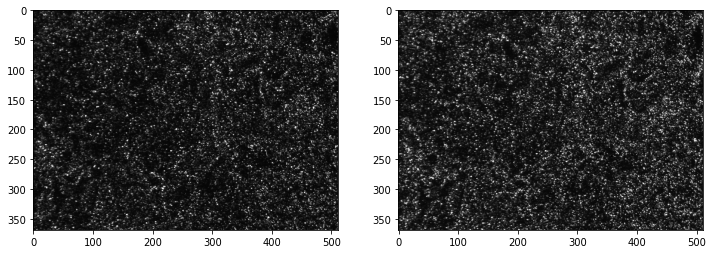

In [6]:
show_pair(frame_a, frame_b)

In [7]:
frame_a = normalize_intensity(frame_a)
frame_b = normalize_intensity(frame_b)


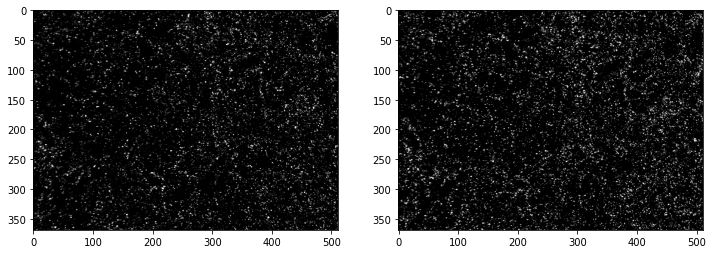

In [8]:
show_pair(frame_a, frame_b)

In [9]:
window_size = 32
overlap = 16
dt=1.0
search_area_size = 32
correlation_method="circular"
subpixel_method="gaussian"
sig2noise_method='peak2peak'

In [10]:
%%time
vel1 = extended_search_area_piv(frame_a, frame_b, window_size=window_size,
               search_area_size=search_area_size, overlap=overlap,dt=dt,
                               correlation_method='circular',
                               subpixel_method=subpixel_method,
                               sig2noise_method=sig2noise_method)

CPU times: user 117 ms, sys: 13.1 ms, total: 131 ms
Wall time: 131 ms


In [11]:
%%time
window_size = 24
search_area_size = 32
vel2 = extended_search_area_piv(frame_a, frame_b, window_size=window_size,
               search_area_size=search_area_size, overlap=overlap,dt=dt,
                               correlation_method='circular',
                               normalized_correlation=True,
                               subpixel_method=subpixel_method,
                               sig2noise_method=sig2noise_method)

CPU times: user 131 ms, sys: 9.04 ms, total: 140 ms
Wall time: 139 ms


In [12]:
%%time
window_size = 24
search_area_size = 32
vel2 = extended_search_area_piv(frame_a, frame_b, window_size=window_size,
               search_area_size=search_area_size, overlap=overlap,dt=dt,
                               correlation_method='linear',
                               subpixel_method=subpixel_method,
                               sig2noise_method=sig2noise_method)

CPU times: user 190 ms, sys: 19.6 ms, total: 210 ms
Wall time: 209 ms


In [13]:
%%time
window_size = 24
search_area_size = 32
vel2 = extended_search_area_piv(frame_a, frame_b, window_size=window_size,
               search_area_size=search_area_size, overlap=overlap,dt=dt,
                               correlation_method='linear',
                               normalized_correlation=True,
                               subpixel_method=subpixel_method,
                               sig2noise_method=sig2noise_method)

CPU times: user 176 ms, sys: 35.4 ms, total: 211 ms
Wall time: 210 ms


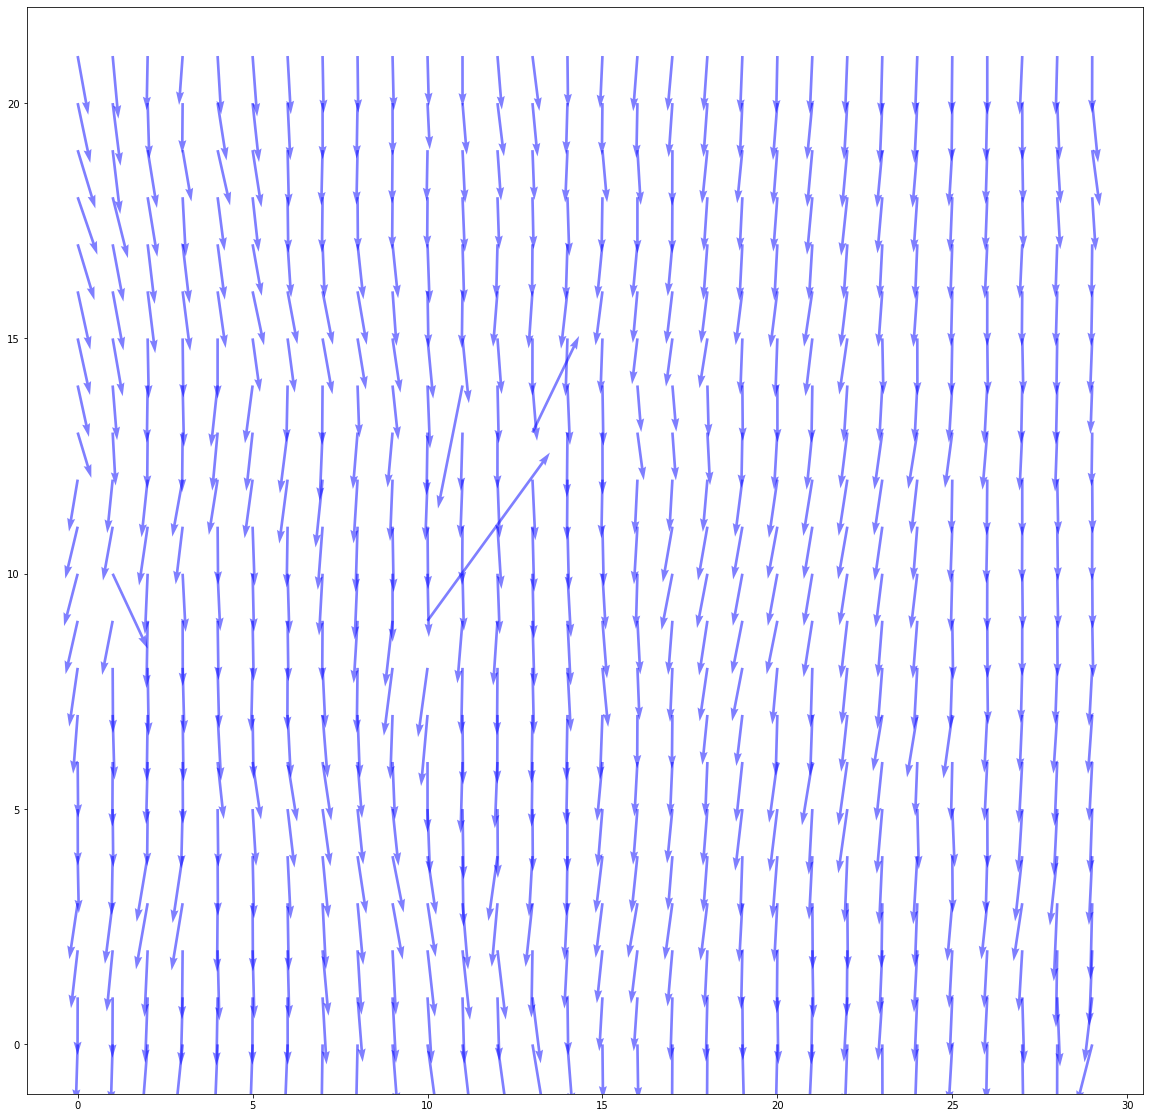

In [16]:
plt.figure(figsize=(20,20))
plt.quiver(vel1[0],-vel1[1],scale=100,color='b',alpha=0.5)